# What Makes A Trending Animal Video?

This notebook focuses on answering that question in the most appropriate way possible, with regression, neural networks, transformers, and the like. Each section is written so you can run the script yourself, although this isn't recommended as it could take gigabytes of storage and hours of processing to deal with all of the data and training.

To simplify the sections, they are below:

0. Base installs for videos/datascience stuff
1. Grab all category information for YouTube videos
2. Retrieve data from the CSV file, download all necessary pieces of data (thumbnails, mp4's, descriptions, etc)
3. Preprocessing the data
4. Modelling and evaluating the data (with evaluations after the definitions/trainings)
5. Conclusions

## 0) Core setup

In [ ]:
%pip install -q clean-text
%pip install -q pytubefix
%pip install -q opendatasets
%pip install -q pandas

import pandas as pd
import json
import os
import requests
from cleantext import clean
from pytubefix import YouTube, exceptions

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.


## Here is a quick thing for actually running this code, where you will have to download the data and put it into a specific folder.

In [ ]:
#getting the dataset
!mkdir ./DS
!wget -q https://huggingface.co/datasets/bagelsause/youtube_dataset/resolve/main/US_category_id.json -O ./DS/US_category_id.json
!wget -q https://huggingface.co/datasets/bagelsause/youtube_dataset/resolve/main/US_youtube_trending_data.csv.zip -O ./DS/US_youtube_trending_data.csv.zip

#unzip the dataset
!unzip -q ./DS/US_youtube_trending_data.csv.zip -d ./DS

## 1) Grab all category information

In [2]:
file = open('./DS/US_category_id.json')
categories = json.load(file)

fullCategories = {}
for i in categories['items']:
    if (i['snippet']['assignable']):
        title = i['snippet']['title']
        ID = i['id']
        print("Assignable Category: " + title + " | ID: " + ID)
        fullCategories[title] = ID

#this code should grab all of the possible category id's available

Assignable Category: Film & Animation | ID: 1
Assignable Category: Autos & Vehicles | ID: 2
Assignable Category: Music | ID: 10
Assignable Category: Pets & Animals | ID: 15
Assignable Category: Sports | ID: 17
Assignable Category: Travel & Events | ID: 19
Assignable Category: Gaming | ID: 20
Assignable Category: People & Blogs | ID: 22
Assignable Category: Comedy | ID: 23
Assignable Category: Entertainment | ID: 24
Assignable Category: News & Politics | ID: 25
Assignable Category: Howto & Style | ID: 26
Assignable Category: Education | ID: 27
Assignable Category: Science & Technology | ID: 28
Assignable Category: Nonprofits & Activism | ID: 29


## 2.1) Get Subset of Cat Group, Clean Data

In [3]:
animalID = int(fullCategories['Pets & Animals'])
print(animalID) #specifically the "pets and animals" ID

15


In [4]:
videodf = pd.read_csv('./DS/US_youtube_trending_data.csv')
specificMetrics = ['video_id', 'title', 'tags', 'view_count', 'likes', 'comment_count', 'thumbnail_link', 'description']
videodf = videodf[videodf['categoryId'] == animalID][specificMetrics]
videodf.head()

#get all videoid's titles, tags, viewcounts, likes, comment_counts, thumbnail links, and descriptions for each "pets and animals" video

,video_id,title,tags,view_count,likes,comment_count,thumbnail_link,description
104,3LqQB4HV8qg,I rescued my cat from the sewer,joey|graceffa|joey graceffa|pregnant cat|rescu...,263450,22669,4591,https://i.ytimg.com/vi/3LqQB4HV8qg/default.jpg,I rescued my cat after she got stuck in the se...
331,3LqQB4HV8qg,I rescued my cat from the sewer,joey|graceffa|joey graceffa|pregnant cat|rescu...,280138,23626,4809,https://i.ytimg.com/vi/3LqQB4HV8qg/default.jpg,I rescued my cat after she got stuck in the se...
556,3LqQB4HV8qg,I rescued my cat from the sewer,joey|graceffa|joey graceffa|pregnant cat|rescu...,291192,24150,4954,https://i.ytimg.com/vi/3LqQB4HV8qg/default.jpg,I rescued my cat after she got stuck in the se...
614,Biagyb7AcK8,True Facts: The Hummingbird Warrior,[None],505104,53244,2866,https://i.ytimg.com/vi/Biagyb7AcK8/default.jpg,Not a moth.SHIRTS: https://ze-true-store.mysho...
783,3LqQB4HV8qg,I rescued my cat from the sewer,joey|graceffa|joey graceffa|pregnant cat|rescu...,298962,24492,4989,https://i.ytimg.com/vi/3LqQB4HV8qg/default.jpg,I rescued my cat after she got stuck in the se...


In [5]:
videodf[videodf['video_id'] == "3LqQB4HV8qg"]
#example video ID, it's trending multiple times, so it was given multiple entries, we don't care about that

,video_id,title,tags,view_count,likes,comment_count,thumbnail_link,description
104,3LqQB4HV8qg,I rescued my cat from the sewer,joey|graceffa|joey graceffa|pregnant cat|rescu...,263450,22669,4591,https://i.ytimg.com/vi/3LqQB4HV8qg/default.jpg,I rescued my cat after she got stuck in the se...
331,3LqQB4HV8qg,I rescued my cat from the sewer,joey|graceffa|joey graceffa|pregnant cat|rescu...,280138,23626,4809,https://i.ytimg.com/vi/3LqQB4HV8qg/default.jpg,I rescued my cat after she got stuck in the se...
556,3LqQB4HV8qg,I rescued my cat from the sewer,joey|graceffa|joey graceffa|pregnant cat|rescu...,291192,24150,4954,https://i.ytimg.com/vi/3LqQB4HV8qg/default.jpg,I rescued my cat after she got stuck in the se...
783,3LqQB4HV8qg,I rescued my cat from the sewer,joey|graceffa|joey graceffa|pregnant cat|rescu...,298962,24492,4989,https://i.ytimg.com/vi/3LqQB4HV8qg/default.jpg,I rescued my cat after she got stuck in the se...


In [6]:
#sort by video id (group common video id's together) then sort by viewcount
df_sorted = videodf.sort_values(by=['video_id', 'view_count'], ascending=[False, False])

#keep first row of each video_id group (the one with the highest count)
cleaneddf = df_sorted.groupby('video_id').first().reset_index()

cleaneddf.head()

,video_id,title,tags,view_count,likes,comment_count,thumbnail_link,description
0,-ZzjDXc-pl8,Crane Introduces His Babies To His Human Best ...,animal video|animals|the dodo|Animal Rescue|do...,5162730,50938,2119,https://i.ytimg.com/vi/-ZzjDXc-pl8/default.jpg,Crane knocks on his human best friend's door e...
1,04KxKOCZGLo,Pretending to Put My Dog on a Diet,pretending to put my dog on a diet|dog diet ch...,2414647,60658,4462,https://i.ytimg.com/vi/04KxKOCZGLo/default.jpg,Pretending to Put My Dog on a DietToday we pre...
2,085oabjiS8U,Brave man rescues exhausted coyote,[None],8429238,36292,3585,https://i.ytimg.com/vi/085oabjiS8U/default.jpg,"When all hope is lost, the greatest gift is a ..."
3,0C2K9jvqtXs,True Facts: The Curious Adaptations of Sharks,[None],1001792,76622,2923,https://i.ytimg.com/vi/0C2K9jvqtXs/default.jpg,Go to https://brilliant.org/zefrank to get a 3...
4,0ka_RArXke8,Dogs Vs Cats | Tofu the Corgi | #shorts,shorts|corgi|dog life|cat life,1818865,130646,1331,https://i.ytimg.com/vi/0ka_RArXke8/default.jpg,Anybody else agree? #shortsFOLLOW TOFU THE COR...


In [7]:
cleaneddf[cleaneddf['video_id'] == "3LqQB4HV8qg"]
#looking at it again, only one entry exists for that video, and it's the entry that was last grabbed (highest viewcount)

,video_id,title,tags,view_count,likes,comment_count,thumbnail_link,description
13,3LqQB4HV8qg,I rescued my cat from the sewer,joey|graceffa|joey graceffa|pregnant cat|rescu...,298962,24492,4989,https://i.ytimg.com/vi/3LqQB4HV8qg/default.jpg,I rescued my cat after she got stuck in the se...


## 2.2.1) Post-cleaning, fetch and store all thumbnails&descriptions of videos
Overarching "YT WORK" folder contains all files necessary, inside "DATA" folder, we create a bunch of folders with the associated "video_id's" that contains the thumbnails, mp4's, & descriptions for the video. First portion focuses on retrieving thumbnails and descriptions (present within the dataframe itself), second focuses on the mp4's.

In [8]:
datapath = "./DATA/"

for index, video in cleaneddf.iterrows():
    videoPath = datapath + video["video_id"]
    #make folder if it doesn't already exist
    if not os.path.exists(videoPath):
        os.makedirs(videoPath)
    
    #YT Work/Data/-ZzjDXc-pl8/
    videoPath += "/"
    
    #save thumbnail as image file in folder
    thumbnail = "http://img.youtube.com/vi/" + video["video_id"] + "/0.jpg"
    
    img_data = requests.get(thumbnail).content
    with open(videoPath + 'image.jpg', 'wb') as handler:
        handler.write(img_data)
    
    #save description as a .txt file in the folder
    f = open(videoPath + "description.txt", "w")
    f.write(clean(video["description"], no_emoji=True))
    f.close()

## 2.2.2) Fetch MP4's of videos

In [9]:
total_completed = 0

for index, video in cleaneddf.iterrows():
    vidID = video['video_id']
    url = "https://www.youtube.com/watch?v=" + vidID
    
    total = cleaneddf.shape[0]
    youtube_content = YouTube(url)
    outpath = "./DATA/"+vidID+"/"

    #try and get the lowest quality of videos possible for analysis (video files themselves not required, but helpful)
    try:
        lowestStream = youtube_content.streams.get_by_resolution("240p").download(max_retries=5, output_path=outpath, filename="video.mp4")
    except AttributeError:
        lowestStream = youtube_content.streams.get_lowest_resolution().download(max_retries=5, output_path=outpath, filename="video.mp4")
    except exceptions.VideoUnavailable:
        pass #if the video isn't available, we'll skip it.
    except Exception as e:
        print(f"\nEXCEPTION:" + str(e) + "| Video ID: " + str(vidID) + f"\n")

    total_completed += 1
    
    if total_completed % 5 == 0:
        print(f"Complete: {round((total_completed/total)*100, 2)}%",
              end='\r')

print(f"Completed 100% of the dataset, all are located in ./DATA/<VIDEOID>\n")

Completed 100% of the dataset, all are located in ./DATA/<VIDEOID>



## 2.3) Final clean of data to only include videos with available thumbnails, descriptions, and mp4's

In [10]:
#go through each folder in the ./DATA/ directory, and remove all that dont have the three files in there.
data_path = "./DATA/"
required_files = ["description.txt", "image.jpg", "video.mp4"]
videos_to_remove = []
total_size = 0

for folder in os.listdir(data_path):
    folder_path = os.path.join(data_path, folder)
    if os.path.isdir(folder_path):
        missing = [file for file in required_files if not os.path.exists(os.path.join(folder_path, file))]

        if missing:
            print(f"Folder '{folder}' is missing files: {', '.join(missing)}. Deleting folder...")
            #nuke the folder from storage
            for root, dirs, files in os.walk(folder_path, topdown=False):
                for file in files:
                    os.remove(os.path.join(root, file))
                for dir in dirs:
                    os.rmdir(os.path.join(root, dir))
            os.rmdir(folder_path)
            #add it to removal list
            videos_to_remove.append(folder)
        else:
            #calculate size of folder
            for root, _, files in os.walk(folder_path):
                for file in files:
                    file_path = os.path.join(root, file)
                    total_size += os.path.getsize(file_path)

if videos_to_remove:
    print(f"Removing entries for video IDs: {', '.join(videos_to_remove)}")
    cleaneddf = cleaneddf[~cleaneddf['video_id'].isin(videos_to_remove)]

print(f"\nTotal size of the DATA directory: {total_size / (1024**3):.2f} GB")

#save the finalized cleaned dataframe
cleaneddf.to_csv("./DATA/cleaned_data.csv")
print("Cleaned and finalized raw data has been stored.")

Folder '3oaf7tLz6O4' is missing files: video.mp4. Deleting folder...
Folder '5VQmGKtNX08' is missing files: video.mp4. Deleting folder...
Removing entries for video IDs: 3oaf7tLz6O4, 5VQmGKtNX08

Total size of the DATA directory: 5.36 GB
Cleaned and finalized raw data has been stored.


## 3) Parse each piece of data into something computer-understandable (pre-processing)

In [ ]:
%pip install -q Pillow
%pip install -q transformers
%pip install -q scikit-learn
%pip install -q torch
%pip install -q opencv-python
%pip install -q timm
%pip install -q ultralytics

from ultralytics import YOLO
from PIL import Image
from sklearn.feature_extraction.text import TfidfVectorizer
import cv2
import numpy as np
from collections import Counter

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
#init the models
#YOLO v8 for segmentation
yolo_model = YOLO("yolov8x.pt")

#tags and descriptions
tfidf_vectorizer = TfidfVectorizer(max_features=100)

data_path = "./DATA/"
output_path = "./DATA/preprocessed_data.csv"

processed_data = []

#for each folder in the data directory
for folder in os.listdir(data_path):
    folder_path = os.path.join(data_path, folder+"/")
    if os.path.isdir(folder_path):
        video_id = folder

        #grab all view/like counts for prediction purposes
        video_data = cleaneddf.loc[cleaneddf["video_id"] == video_id]
        if not video_data.empty:
            view_count = int(video_data["view_count"].values[0])
            like_count = int(video_data["likes"].values[0])
        else:
            #case where its undefined (never should happen, but just in case)
            view_count = 0
            like_count = 0

        #process the tnumbnail
        thumbnail_path = os.path.join(folder_path, "image.jpg")
        object_counts = {}
        if os.path.exists(thumbnail_path):
            try:
                #load the image
                image = Image.open(thumbnail_path).convert("RGB")
                results = yolo_model.predict(image)  #run YOLO on the image

                detected_objects = [box.cls for box in results[0].boxes]  # Class IDs of detected objects
                class_names = [yolo_model.names[int(cls)] for cls in detected_objects]  # Convert IDs to names
                object_counts = Counter(class_names)
            except Exception as e:
                print(f"Error processing thumbnail for {video_id}: {e}")
                object_counts = {}
        
        #load each object as one-hot encoded of all possible objects
        all_possible_objects = list(yolo_model.names.values())
        thumbnail_features = {obj: object_counts.get(obj, 0) for obj in all_possible_objects}

        #process the description with tf.idf vectorizers
        description_path = os.path.join(folder_path, "description.txt")
        with open(description_path, "r", encoding="utf-8") as f:
            description = f.read().strip()
        #ensure description isnt empty
        if description:
            try:
                description_vector = tfidf_vectorizer.fit_transform([description]).toarray().flatten()
            except ValueError as e:
                print(f"Error processing description for {video_id}: {e}")
                description_vector = np.zeros(100)
        else:
            description_vector = np.zeros(100)

        #processing the tags
        tags = cleaneddf.loc[cleaneddf["video_id"] == video_id, "tags"].values
        if len(tags) > 0:
            tags_vector = tfidf_vectorizer.fit_transform(tags).toarray().mean(axis=0)
        else:
            #in case we have no tags
            tags_vector = np.zeros(100)

        #process the video's general features (no in-depth analysis yet)
        video_path = os.path.join(folder_path, "video.mp4")
        if os.path.exists(video_path):
            try:
                cap = cv2.VideoCapture(video_path)
                frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
                fps = int(cap.get(cv2.CAP_PROP_FPS))
                duration = frame_count / fps if fps > 0 else 0

                #just logging the basic features for now
                video_features = [frame_count, fps, duration]

                cap.release()
            except Exception as e:
                print(f"Error processing video for {video_id}: {e}")
                video_features = [0, 0, 0]
        else:
            video_features = [0, 0, 0]

        #combine all features into a single row
        processed_data.append({
            "video_id": video_id,
            "view_count": view_count, #prediction only!!!
            "like_count": like_count, #prediction only!!!
            **thumbnail_features,  #add one-hot encoded object counts as separate columns, rather than raw dictionary
            "description_vector": description_vector.tolist(),
            "tags_vector": tags_vector.tolist(),
            "video_features": video_features
        })

#convert processed into dataframe and save
processed_df = pd.DataFrame(processed_data)
processed_df.to_csv(output_path, index=False)
print(f"Preprocessed data saved to {output_path}")


0: 480x640 1 person, 1 bird, 593.2ms
Speed: 2.9ms preprocess, 593.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 dog, 1 bowl, 1 dining table, 561.4ms
Speed: 1.7ms preprocess, 561.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 dog, 1 sports ball, 628.2ms
Speed: 1.9ms preprocess, 628.2ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 birds, 569.0ms
Speed: 1.6ms preprocess, 569.0ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 dog, 578.5ms
Speed: 1.8ms preprocess, 578.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 dog, 616.7ms
Speed: 1.4ms preprocess, 616.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 dogs, 1 chair, 563.1ms
Speed: 1.7ms preprocess, 563.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bear, 1 s

In [24]:
processed_df.head()

,video_id,view_count,like_count,person,bicycle,car,motorcycle,airplane,bus,train,...,book,clock,vase,scissors,teddy bear,hair drier,toothbrush,description_vector,tags_vector,video_features
0,-ZzjDXc-pl8,5162730,50938,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,"[0.05285164225816899, 0.05285164225816899, 0.0...","[0.24253562503633297, 0.6063390625908325, 0.12...","[5877, 29, 202.6551724137931]"
1,04KxKOCZGLo,2414647,60658,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,"[0.0510976130307596, 0.0510976130307596, 0.051...","[0.0582222509739582, 0.0582222509739582, 0.116...","[2863, 30, 95.43333333333334]"
2,085oabjiS8U,8429238,36292,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,"[0.07088812050083358, 0.07088812050083358, 0.2...",[1.0],"[5399, 29, 186.17241379310346]"
3,0C2K9jvqtXs,1001792,76622,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,"[0.018505830254940132, 0.33310494458892237, 0....",[1.0],"[21636, 23, 940.695652173913]"
4,0ka_RArXke8,1818865,130646,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,"[0.10540925533894598, 0.10540925533894598, 0.1...","[0.35355339059327373, 0.35355339059327373, 0.3...","[394, 30, 13.133333333333333]"


# Now that we have all of the data pre-processed, we can now start to work on the actual modelling!!

In [1]:
import pandas as pd
import numpy as np

#dataset to work with (so you can run this separately)
full_dataset = pd.read_csv('./DATA/preprocessed_data.csv')
full_dataset.head(1)

,video_id,view_count,like_count,person,bicycle,car,motorcycle,airplane,bus,train,...,book,clock,vase,scissors,teddy bear,hair drier,toothbrush,description_vector,tags_vector,video_features
0,-ZzjDXc-pl8,5162730,50938,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,"[0.05285164225816899, 0.05285164225816899, 0.0...","[0.24253562503633297, 0.6063390625908325, 0.12...","[5877, 29, 202.6551724137931]"


## 4.1) Custom regression model (no pytorch just yet) 

In [3]:
#taking inspiration from the gradient-descent models we did in PA4

#first we have to flatten the columns

#description and tags are weird since theyre not all 100
description_vectors = full_dataset['description_vector'].apply(eval)
description_vectors = description_vectors.apply(lambda x: x if len(x) == 100 else [0] * 100)
description_vectors = np.array(description_vectors.tolist())
tags_vectors = full_dataset['tags_vector'].apply(eval)
tags_vectors = tags_vectors.apply(lambda x: x if len(x) == 100 else [0] * 100)
tags_vectors = np.array(tags_vectors.tolist())


video_features = np.array(full_dataset['video_features'].apply(eval).tolist())

#setting all of X's features as the one-hots, description, tags, and video features (excl viewcount, likecount, and id)
X = np.hstack([full_dataset.iloc[:, 3:-3].values, description_vectors, tags_vectors, video_features])
y = full_dataset['view_count'].values #could be like_count aswell, but "trending" is views

#actual regression model
class CustomRegressionModel:
    def __init__(self, learning_rate=0.01, epochs=1000, scheduler=None):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.scheduler = scheduler
        self.weights = None
        self.bias = None

    def init_parameters(self, n_features):
        """Given the number of features, initialize weights"""
        self.weights = np.random.randn(n_features) * 0.01 #small random values
        self.bias = 0

    def predict(self, X):
        """Linear prediction of value X with weights and bias"""
        return np.dot(X, self.weights) + self.bias
    
    def compute_loss(self, y_true, y_pred):
        """Given the h_theta and y, compute MSE"""
        l2_penalty = 0.01 * np.sum(self.weights**2) #l2 regularization
        return np.mean((y_true - y_pred)**2) + l2_penalty
    
    def compute_gradients(self, X, y_true, y_pred):
        """Compute the gradients for the current set of weights"""
        n_samples = X.shape[0]

        delta_weights = -(2 / n_samples) * np.dot(X.T, (y_true - y_pred)) + 0.02 * self.weights #l2 gradient
        delta_bias    = -(2 / n_samples) * np.sum(y_true - y_pred)
        return delta_weights, delta_bias
    
    def get_learning_vals(self):
        """Gets all learned values"""
        return self.bias, self.weights

    def fit(self, X, y, verbose=True):
        """Learning/fitting function for the weights"""
        self.init_parameters(X.shape[1])

        losses = []
        best_loss = float('inf')
        patience = 100 #early stopping patience
        patience_counter = 0

        for epoch in range(self.epochs):
            y_pred = self.predict(X)
            loss = self.compute_loss(y, y_pred)

            #add losses pre-update to history
            losses.append(loss)

            #check if we have a new best loss
            if loss < best_loss:
                best_loss = loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    if verbose:
                        print(f"Early stopping at epoch {epoch}")
                    break

            #check if we have a scheduler and run it if we do
            if self.scheduler:
                self.learning_rate = self.scheduler(epoch, self.learning_rate)

            #calc gradients and run an update
            dw, db = self.compute_gradients(X, y, y_pred)
            self.weights -= self.learning_rate * dw
            self.bias    -= self.learning_rate * db

            if epoch % 50 == 0 and verbose:
                print(f"Epochs completed: {round((epoch/self.epochs) * 100, 2)}%", end='\r')

        if verbose:
            print(f"Epochs completed: 100.00%")

        return losses
    
    def evaluate(self, X, y):
        #predict and compute MSE value for epoch-specific evaluation
        y_pred = self.predict(X)
        return self.compute_loss(y, y_pred)
    
#step decay scheduler, reducing the learning rate every 100 epochs
def step_decay_scheduler(epoch, current_lr, drop=0.5, epochs_drop=100):
    if epoch % epochs_drop == 0 and epoch > 0:
        return current_lr * drop
    return current_lr

Before working with our actual data, let's sanity-check it with some synthetic data

In [3]:
synthetic_data = {
    "cat": [1, 0, 1, 0, 1],
    "dog": [0, 1, 0, 1, 0],
    "table": [1, 1, 0, 0, 1],
    "chair": [0, 0, 1, 1, 0],
    "description_vector": [[0.1] * 100] * 5,  #fake description vectors
    "tags_vector": [[0.2] * 100] * 5,         #fake tags vectors
    "video_features": [[300, 30, 10]] * 5,    #fake video features (frame count, fps, duration)
    "view_count": [100000000, 50000000, 75000000, 25000000, 125000000]  #fake view counts
}
synthetic_df = pd.DataFrame(synthetic_data)
synth_description_vectors = np.array(synthetic_df["description_vector"].tolist())
synth_tags_vectors = np.array(synthetic_df["tags_vector"].tolist())
synth_video_features = np.array(synthetic_df["video_features"].tolist())
X_synthetic = np.hstack([synthetic_df[["cat", "dog", "table", "chair"]].values,
                         synth_description_vectors,
                         synth_tags_vectors,
                         synth_video_features])
y_synthetic = synthetic_df["view_count"].values

#normalize features and target variable
X_mean_synth = np.mean(X_synthetic, axis=0)
X_std_synth = np.std(X_synthetic, axis=0)
X_std_synth[X_std_synth == 0] = 1
X_synthetic = (X_synthetic - X_mean_synth) / X_std_synth

y_mean_synth = np.mean(y_synthetic)
y_std_synth = np.std(y_synthetic)
y_synthetic = (y_synthetic - y_mean_synth) / y_std_synth

split_idx = int(0.8 * len(X_synthetic))
X_train_synthetic, X_test_synthetic = X_synthetic[:split_idx], X_synthetic[split_idx:]
y_train_synthetic, y_test_synthetic = y_synthetic[:split_idx], y_synthetic[split_idx:]

#apply log transform on target
y_synthetic_log = np.log1p(synthetic_df["view_count"].values)  # log1p(x) = log(1 + x)

#normalize the log-transformed target variable
y_mean_log = np.mean(y_synthetic_log)
y_std_log = np.std(y_synthetic_log)
y_synthetic_log = (y_synthetic_log - y_mean_log) / y_std_log

#split into training and testing sets
y_train_synthetic_log, y_test_synthetic_log = y_synthetic_log[:split_idx], y_synthetic_log[split_idx:]

## Actually training the model here:

model = CustomRegressionModel(learning_rate=0.001, epochs=10000, scheduler=step_decay_scheduler)
losses = model.fit(X_train_synthetic, y_train_synthetic_log)

#evaluate the model
train_mse = model.evaluate(X_train_synthetic, y_train_synthetic_log)
test_mse = model.evaluate(X_test_synthetic, y_test_synthetic_log)

#reverse the log transformation for predictions
y_pred_log = model.predict(X_test_synthetic)
y_pred_original = np.expm1((y_pred_log * y_std_log) + y_mean_log)
y_test_original = np.expm1((y_test_synthetic_log * y_std_log) + y_mean_log)

#compute MSE on the original scale
mse_original_scale = np.mean((y_test_original - y_pred_original) ** 2)

#display results
print(f"Training MSE (Log-Transformed): {train_mse:.4f}")
print(f"Testing MSE (Log-Transformed): {test_mse:.4f}")
print(f"Testing MSE (Original Scale): {mse_original_scale:.4f}")

#instead of MSE, we could possibly use MAPE (Mean Absolute Percentage Error) for a more interpretable metric
mape_original_scale = np.mean(np.abs((y_test_original - y_pred_original) / y_test_original)) * 100
print(f"Testing MAPE (Original Scale): {mape_original_scale:.2f}%")

Early stopping at epoch 4700
Epochs completed: 100.00%
Training MSE (Log-Transformed): 0.1795
Testing MSE (Log-Transformed): 0.4154
Testing MSE (Original Scale): 1465790789751329.5000
Testing MAPE (Original Scale): 30.63%


Now that the results look good (relatively) in regards to MAPE lets actually run it on our data.

In [4]:
##doing pretty much the same thing as above, but with the real data
#normalize the features
mean = np.mean(X, axis=0)
std = np.std(X, axis=0)
std[std == 0] = 1
X = (X - mean) / std

y_log = np.log1p(y)  # log1p(x) = log(1 + x)

#normalize the log-transformed target variable
y_mean = np.mean(y_log)
y_std = np.std(y_log)
y_log = (y_log - y_mean) / y_std

#split into training/testing 80/20
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_log_train, y_log_test = y_log[:split_idx], y_log[split_idx:]

#check real quick if any nan's exist anywhere
if np.isnan(X).any():
    print("Warning: NaN values detected in the feature matrix!")

Completed scanning all learning rates and decayers.
Top 5 Results:
Learning Rate: 0.0003527236180904523, Decayer: False, MSE: 3110512620577.4990, MAPE: 158.53%
Learning Rate: 0.0004029698492462312, Decayer: False, MSE: 3208166523954.9541, MAPE: 156.84%
Learning Rate: 0.00030247738693467343, Decayer: False, MSE: 3267566598310.0776, MAPE: 161.38%
Learning Rate: 0.008995075376884421, Decayer: True, MSE: 3282245526457.7515, MAPE: 152.07%
Learning Rate: 0.000503462311557789, Decayer: False, MSE: 3321476432493.0234, MAPE: 161.21%


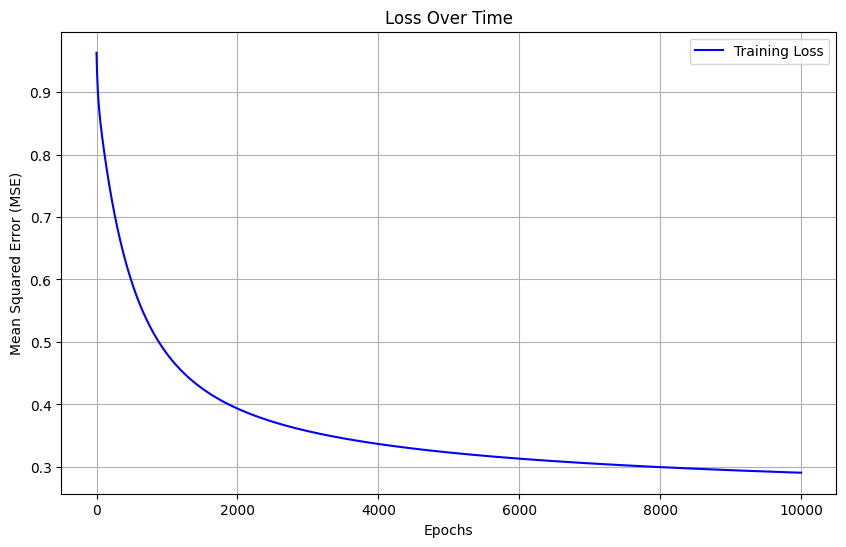

Given the best learning rate of 0.0003527236180904523 and decayer of False, we tested again and found: 
MSE of 3697471070977.4360 and MAPE of 167.90%


In [ ]:
import matplotlib.pyplot as plt

def test_custom_linear_regression(learning_rate, plot=False, decayer=False):
    epchs = 10000

    #first we train it on our data (using decayer if we want to)
    model = CustomRegressionModel(learning_rate=learning_rate, epochs=epchs, scheduler=step_decay_scheduler) if decayer else CustomRegressionModel(learning_rate=learning_rate, epochs=epchs)
    losses = model.fit(X_train, y_log_train, verbose=False)

    #then we plot it if true
    if plot:
        plt.figure(figsize=(10, 6))
        plt.plot(range(len(losses)), losses, label="Training Loss", color="blue")
        plt.title("Loss Over Time")
        plt.xlabel("Epochs")
        plt.ylabel("Mean Squared Error (MSE)")
        plt.legend()
        plt.grid()
        plt.show()


    #show the MSE results
    train_mse = model.evaluate(X_train, y_log_train) #strictly MSE in the log space, not directly used
    test_mse = model.evaluate(X_test, y_log_test) #strictly MSE in the log space, not directly used

    #reverse the log transformation for predictions
    y_pred_log = model.predict(X_test)
    y_pred_original = np.expm1((y_pred_log * y_std) + y_mean)
    y_test_original = np.expm1((y_log_test * y_std) + y_mean)

    #compute MSE on the original scale
    mse_original_scale = np.mean((y_test_original - y_pred_original) ** 2)

    #instead of MSE, we use MAPE
    mape_original_scale = np.mean(np.abs((y_test_original - y_pred_original) / y_test_original)) * 100

    return mse_original_scale, mape_original_scale

#testing the model with a search space of learning rates (200 total values) and decayer or not (2 values, yes or no), total of 400 values
learning_rates = np.linspace(0.000001, 0.01, 200)
decayer = [True, False]
results = []
for lr in learning_rates:
    for d in decayer:
        print(f"Now on: learning Rate: {lr:.6f}, Decayer: {str(d)[0]}", end="\r")

        mse, mape = test_custom_linear_regression(lr, plot=False, decayer=d)
        results.append((lr, d, mse, mape))
        #print(f"Learning Rate: {lr}, Decayer: {d}, MSE: {mse:.4f}, MAPE: {mape:.2f}%")

print("Completed scanning all learning rates and decayers.")

#sort results by MSE, print top 5
sorted_results = sorted(results, key=lambda x: x[2])
print("Top 5 Results:")
for lr, d, mse, mape in sorted_results[:5]:
    print(f"Learning Rate: {lr}, Decayer: {d}, MSE: {mse:.4f}, MAPE: {mape:.2f}%")

#plot the best result
best_result = sorted_results[0]
best_lr, best_decayer, best_found_mse, best_found_mape = best_result
experimented_mse, experimented_mape = test_custom_linear_regression(best_lr, plot=True, decayer=best_decayer)
print(f"Given the best learning rate of {best_lr} and decayer of {best_decayer}, we tested again and found: \nMSE of {experimented_mse:.4f} and MAPE of {experimented_mape:.2f}%")

Looking at those top 5 values, we can clearly see a trend of the best learning rates and if a decayer is actually useful based on the MAPE value, and we can see the raw MSE in the original scale and MAPE values in that last returned line. With this, we can see that it is difficult to get an exact linear regression since we have a bunch of features, and not all features have the same "weight"/importance that the "one-hot"-equivalent features have.

### Result:
A `step_decay_scheduler`, as we previously defined, seems to somewhat impact the result, however, it seems as though our lowest MSE (in the original space) is around `3,697,471,070,977.4360`, with the MAPE being around ~`170`%. And, since the initial values of the weights are generated randomly, even though we chose the best searched value, we didn't get exactly the same result as before. This means that technically, if we were to randomize it further, we could do better, however, it seems as though we are hitting a low limit with just a normal regression model.

Technically, we could add more features or control it further by specifying what weights should be emphasized, but treating them as all "the same", even with standardized/logged features, we still get a large resulting MSE and MAPE value.

## 4.2) Baseline sklearn regression model (scoring by mean-squared-error) Our end goal is to at least get a better score than this.

Now that we have our custom regression model, let's see if it actually performs better than the sklearn regression model!

Epochs completed: 100.00%
Sklearn Linear Regression - MSE (Original Scale): 16853464201954518.0000
Sklearn Linear Regression - MAPE (Original Scale): 361.33%


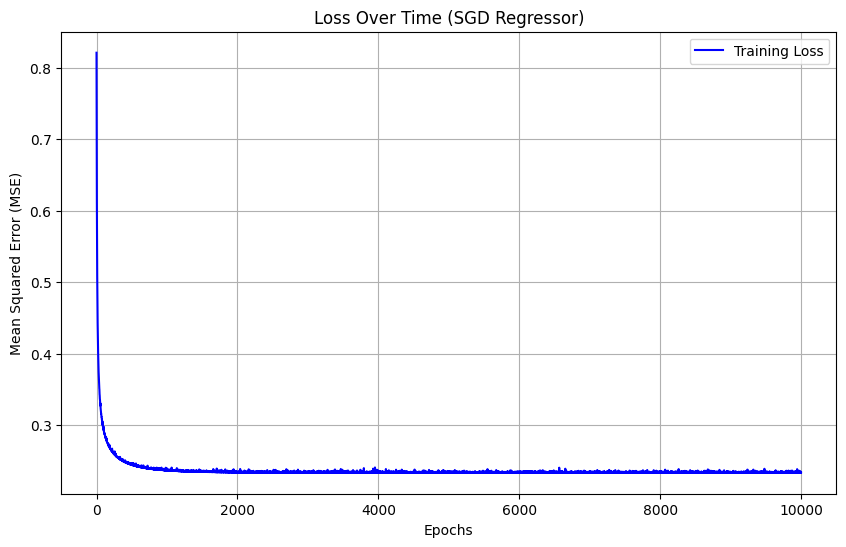

In [7]:
from sklearn.linear_model import SGDRegressor #using stochastic gradient descent for sklearn's linear regression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

#for ignoring any warnings from skLearn (we only do this because we want to map the losses to the epochs)
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

#initialize sklearn's SGD Regression model (loss="squared_error" is the default, but just to be explicit)
#all parameters here are attempting to match the custom model as closely as possible
sklearn_model = SGDRegressor(loss="squared_error",
                             learning_rate='constant',
                             max_iter=1,
                             warm_start=True,
                             eta0=0.0003527236180904523, #learning rate (0.0003527236180904523 is the best learning rate found from the custom model)
                             alpha=0.01) #l2 regularization

losses = []

#same epoch range as before, so we can directly compare the two @10k epochs
for epoch in range(10000):
    sklearn_model.fit(X_train, y_log_train)
    y_log_pred_train = sklearn_model.predict(X_train)
    loss = mean_squared_error(y_log_train, y_log_pred_train)
    losses.append(loss)

    print(f"Epochs completed: {round((epoch/10000) * 100, 2)}%", end='\r')
print(f"Epochs completed: 100.00%")

#predict on the test set
y_log_pred_sklearn = sklearn_model.predict(X_test)
y_log_pred_sklearn = np.clip(y_log_pred_sklearn, -1e2, 1e2) #clip value further to avoid runtime overflows

#reverse the log transformation for predictions
y_pred_original_sklearn = np.expm1((y_log_pred_sklearn * y_std) + y_mean)
y_test_original_sklearn = np.expm1((y_log_test * y_std) + y_mean)

#clip both values to 0 and limit infinity (since we can't have negative views)
y_pred_original_sklearn = np.clip(y_pred_original_sklearn, 0, 1e10)
y_test_original_sklearn = np.clip(y_test_original_sklearn, 0, 1e10)

#compute MSE and MAPE on the original scale
mse_sklearn = mean_squared_error(y_test_original_sklearn, y_pred_original_sklearn)
mape_sklearn = mean_absolute_percentage_error(y_test_original_sklearn, y_pred_original_sklearn) * 100

#print the results
print(f"Sklearn Linear Regression - MSE (Original Scale): {mse_sklearn:.4f}")
print(f"Sklearn Linear Regression - MAPE (Original Scale): {mape_sklearn:.2f}%")

#plot the losses over time
plt.figure(figsize=(10, 6))
plt.plot(range(len(losses)), losses, label="Training Loss", color="blue")
plt.title("Loss Over Time (SGD Regressor)")
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error (MSE)")
plt.legend()
plt.grid()
plt.show()

Again, the MSE displayed in the graph is shown in the log scale, so we could see that on average, it's hovering around the 0.4 mark. However, when looking at the MSE and MAPE in the original scales, we can clearly see the comparisons between the custom and the sklearn models:

Custom MSE: 3697471070977.4360

SkLearn MSE: 16853464201954518.0000

Custom MAPE: 167.90%

SkLearn MAPE: 361.33%
<br>
<br>
Just comparing the Custom regression model versus SkLearn's model (that is customized to be as close as possible to ours, and has been tested strenuously in the past with different epoch and configuration values), our regression model tends to perform better in terms of MSE and MAPE.

Now, to enforce my point, I will perform hyperparameter search on the SkLearn's SGD model and show the best MSE and MAPE values!

<strong>PLEASE KEEP IN MIND, THE FOLLOWING CODE TESTS ~1.6 MILLION POSSIBLE COMBINATIONS OF FEATURES, IT IS REPEATABLE WITH THE RANDOM_STATE OF 42, SO I WOULDNT RECOMMEND YOU RUNNING IT UNLESS YOU WANT TO TAKE UP YOUR CPU FOR HALF AN HOUR OR LONGER</strong>

In [10]:
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

#for ignoring any warnings from skLearn (we only do this because we want to map the losses to the epochs)
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

#defining hyperparameter search space
loss_functions = ['squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive']
learning_rates = ['constant', 'optimal', 'invscaling', 'adaptive']
penalties = ['l2', 'l1', 'elasticnet', None]  #regularization penalties
l1_ratios = np.linspace(0, 1, 5)  #l1 ratio for elasticnet
etas = np.linspace(0.00001, 0.01, 10)  #learning rate values
alphas = np.linspace(1e-5, 0.1, 10)  #regularization strength
max_iters = np.linspace(1000, 10000, 5)  #number of iterations
epsilons = np.linspace(0.1, 0.5, 10)  #epsilon values for epsilon-insensitive loss

results = []

#perform grid search
for loss in loss_functions:
    for learning_rate in learning_rates:
        for eta in etas:
            print(f"Currently on: Loss: {loss} | LR of: {learning_rate} | Eta of: {eta:.4f}", end="\r")
            for alpha in alphas:
                for epsilon in epsilons:
                    for penalty in penalties:
                        for l1_ratio in l1_ratios:
                            for max_iter in max_iters:
                                if loss == 'epsilon_insensitive' and learning_rate != 'constant':
                                    #epsilon-insensitive loss only works with constant learning rate
                                    continue

                                #convert iterations to int
                                max_iter = int(max_iter)

                                #initialize the model with current hyperparameters
                                model = SGDRegressor(
                                    loss=loss,
                                    learning_rate=learning_rate,
                                    eta0=eta,
                                    alpha=alpha,
                                    max_iter=max_iter,
                                    epsilon=epsilon,
                                    penalty=penalty,
                                    l1_ratio=l1_ratio,
                                    random_state=42, #set a random state for reproducibility
                                    warm_start=False
                                )
                                
                                #train the model
                                model.fit(X_train, y_log_train)
                                
                                #predict on the test set
                                y_log_pred = model.predict(X_test)
                                y_log_pred = np.clip(y_log_pred, -1e2, 1e2) #clip values to avoid overflow
                                
                                #reverse the log transformation for predictions
                                y_pred_original = np.expm1((y_log_pred * y_std) + y_mean)
                                y_test_original = np.expm1((y_log_test * y_std) + y_mean)
                                
                                #clip values to avoid invalid numbers
                                y_pred_original = np.clip(y_pred_original, 0, 1e10)
                                y_test_original = np.clip(y_test_original, 0, 1e10)
                                
                                #compute MSE and MAPE
                                mse = mean_squared_error(y_test_original, y_pred_original)
                                mape = mean_absolute_percentage_error(y_test_original, y_pred_original) * 100
                                
                                #store the results
                                results.append({
                                    'loss': loss,
                                    'learning_rate': learning_rate,
                                    'eta0': eta,
                                    'alpha': alpha,
                                    'max_iter': max_iter,
                                    'epsilon': epsilon,
                                    'penalty': penalty,
                                    'l1_ratio': l1_ratio,
                                    'mse': mse,
                                    'mape': mape
                                })

                        if penalty != 'elasticnet':
                            #l1 ratio is only used for elasticnet penalty (sk documentation said not)
                            break

                    if loss == 'squared_error':
                        #squared error doesn't need to be tested with different epsilons (sk documentation said not)
                        break

            if learning_rate == 'optimal':
                #optimal learning rate doesn't need to be tested with different etas (sk documentation said not)
                break

#sort results by MAPE
sorted_results = sorted(results, key=lambda x: x['mse'])

#print the top 5 results
print("Top 5 Results:")
for res in sorted_results[:5]:
    print(f"Loss: {res['loss']}, Learning Rate: {res['learning_rate']}, "
          f"Eta0: {res['eta0']:.6f}, Alpha: {res['alpha']}, Max Iter: {res['max_iter']}, "
          f"Epsilon: {res['epsilon']:.2f}, Penalty: {res['penalty']}, L1 Ratio: {res['l1_ratio']:.2f}, "
          f"MSE: {res['mse']:.4f}, MAPE: {res['mape']:.2f}%")

Top 5 Results:Loss: squared_epsilon_insensitive | LR of: adaptive | Eta of: 0.010000
Loss: epsilon_insensitive, Learning Rate: constant, Eta0: 0.010000, Alpha: 0.08889000000000001, Max Iter: 1000, Epsilon: 0.46, Penalty: l2, L1 Ratio: 0.00, MSE: 2221794936689.0044, MAPE: 135.80%
Loss: epsilon_insensitive, Learning Rate: constant, Eta0: 0.010000, Alpha: 0.08889000000000001, Max Iter: 3250, Epsilon: 0.46, Penalty: l2, L1 Ratio: 0.00, MSE: 2221794936689.0044, MAPE: 135.80%
Loss: epsilon_insensitive, Learning Rate: constant, Eta0: 0.010000, Alpha: 0.08889000000000001, Max Iter: 5500, Epsilon: 0.46, Penalty: l2, L1 Ratio: 0.00, MSE: 2221794936689.0044, MAPE: 135.80%
Loss: epsilon_insensitive, Learning Rate: constant, Eta0: 0.010000, Alpha: 0.08889000000000001, Max Iter: 7750, Epsilon: 0.46, Penalty: l2, L1 Ratio: 0.00, MSE: 2221794936689.0044, MAPE: 135.80%
Loss: epsilon_insensitive, Learning Rate: constant, Eta0: 0.010000, Alpha: 0.08889000000000001, Max Iter: 10000, Epsilon: 0.46, Penalty

In these examples, we are again sorting by MSE, and we can see that with the SkLearn parameter optimization (and doing things like keeping the learning rate constant and having iterations around 1,000), we do end up getting better results, comparing our MSE's of `2,221,794,936,689.0044` (SK) to `3,697,471,070,977.4360`(base custom). 

### First conclusion about this mini section:
Although with parameter optimization we ended up getting a better result than our Custom model, with the same general concepts and hyperparameters applied, we ended up performing better with our custom model by a sizeable factor, meaning that we got some form of success with our constants! Not necessarily better than the "best of the best" SGD parameters, but still something!

To dig a bit further, let's try and see if we could alter our model to use optimal SkLearn parameters: the epsilon_insensitive loss function, a constant learning rate of 0.01, alpha of 0.08889000000000001, and max iterations of 1000, epsilon of 0.46, and only l2 penalty and see if we can get some improvement using an altered custom model vs the sklearn's optimized model!

In [4]:
class OptimizedRegressionModel:
    def __init__(self, learning_rate=0.01, epochs=1000, epsilon=0.46, alpha=0.08889):
        self.learning_rate = learning_rate #eta0=0.01
        self.epochs = epochs #max_iter=1000
        self.epsilon = epsilon  #epsilon=0.46
        self.alpha = alpha  #alpha=0.08889 (l2 reg strength)
        self.weights = None
        self.bias = None

    def init_parameters(self, n_features):
        """Initialize weights and bias."""
        self.weights = np.random.randn(n_features) * 0.01 
        self.bias = 0

    def predict(self, X):
        """Linear prediction."""
        return np.dot(X, self.weights) + self.bias
    
    def compute_loss(self, y_true, y_pred):
        """Compute epsilon-insensitive loss with L2 regularization."""
        errors = np.abs(y_true - y_pred) - self.epsilon
        errors = np.maximum(errors, 0)  #apply epsilon-insensitive threshold

        l2_penalty = self.alpha * np.sum(self.weights**2)  #l2 regularization (same as before, but now parameterized alpha)
        return np.mean(errors**2) + l2_penalty
    
    def compute_gradients(self, X, y_true, y_pred):
        """Compute gradients for weights and bias."""
        n_samples = X.shape[0]

        residuals = y_true - y_pred
        mask = np.abs(residuals) > self.epsilon  #only update for residuals > epsilon

        delta_weights = -(2 / n_samples) * np.dot(X[mask].T, residuals[mask]) + 2 * self.alpha * self.weights
        delta_bias    = -(2 / n_samples) * np.sum(residuals[mask])
        
        return delta_weights, delta_bias
    
    def fit(self, X, y, verbose=True):
        """Train the model using gradient descent."""
        self.init_parameters(X.shape[1])
        losses = []

        for epoch in range(self.epochs):
            y_pred = self.predict(X)
            loss = self.compute_loss(y, y_pred)
            losses.append(loss)

            #compute gradients and update weights and bias
            dw, db = self.compute_gradients(X, y, y_pred)
            self.weights -= self.learning_rate * dw
            self.bias    -= self.learning_rate * db

            if verbose and epoch % 100 == 0:
                print(f"Epoch {epoch}/{self.epochs}, Loss: {loss:.4f}")

        return losses
    
    def evaluate(self, X, y):
        """Evaluate the model on a dataset."""
        y_pred = self.predict(X)
        return self.compute_loss(y, y_pred)

In [16]:
#now that we have that class definition, let's actually train it and see how it does!
model = OptimizedRegressionModel(learning_rate=0.01, epochs=1000, epsilon=0.46, alpha=0.08889)

#fit
losses = model.fit(X_train, y_log_train, verbose=True)

#eval the model
train_mse = model.evaluate(X_train, y_log_train)
test_mse = model.evaluate(X_test, y_log_test)

#reverse the log transformation for predictions
y_pred_log = model.predict(X_test)
y_pred_original = np.expm1((y_pred_log * y_std) + y_mean)
y_test_original = np.expm1((y_log_test * y_std) + y_mean)

#clip both values to 0 and limit infinity (since we can't have negative views)
y_pred_original = np.clip(y_pred_original, 0, 1e10)
y_test_original = np.clip(y_test_original, 0, 1e10)

#compute MSE on the original scale
mse_original_scale = np.mean((y_test_original - y_pred_original) ** 2)

#compute MAPE on the original scale
mape_original_scale = np.mean(np.abs((y_test_original - y_pred_original) / y_test_original)) * 100

print(f"Training MSE (Log-Transformed): {train_mse:.4f}")
print(f"Testing MSE (Log-Transformed): {test_mse:.4f}")
print(f"Testing MSE (Original Scale): {mse_original_scale:.4f}")
print(f"Testing MAPE (Original Scale): {mape_original_scale:.2f}%")

Epoch 0/1000, Loss: 0.3900
Epoch 100/1000, Loss: 0.1500
Epoch 200/1000, Loss: 0.1419
Epoch 300/1000, Loss: 0.1407
Epoch 400/1000, Loss: 0.1407
Epoch 500/1000, Loss: 0.1411
Epoch 600/1000, Loss: 0.1415
Epoch 700/1000, Loss: 0.1432
Epoch 800/1000, Loss: 0.1423
Epoch 900/1000, Loss: 0.1423
Training MSE (Log-Transformed): 0.1427
Testing MSE (Log-Transformed): 0.7716
Testing MSE (Original Scale): 2423766847630.3486
Testing MAPE (Original Scale): 141.32%


With that, we can see that our updated MSE on the original scale is `2,423,766,847,630.3486`, which is definitely an improvement from the original parameters (with an improvement of ~600 billion MSE), but it is still lacking in comparison to the ~200 billion MSE further improvement.

### Second conclusion about this mini section:

Although we did perform better with our naive estimates in comparison to SkLearn, and after optimizing more hyperparameters we got a better result and ended up having a higher MSE than SkLearn, our average MSE are still in the trillions, which is absolutely not good in regards to youtube video viewcounts. It's a better analysis than just guessing random numbers, but we couldn't get an accurate enough prediction to extrapolate any data from it. Maybe, it's not as simple as "cat+dog=100M views", maybe something outside of a regression model, something more like a neural network, might perform better with predictions.

### 4.2.5) Large tangent, feature representation

With these results, I had the idea that maybe the actual data features were too much, as it might take longer for a system to finalize it's results (or optimal feature weights), so in this subsection, I will go about with only having two X features per datapoint, the "thumbnail contents" and "video features", as those are the primary things the user would see before actually clicking/viewing the video.

In [5]:
#the "thumbnail images" should be a singular array with the encoded values
#the "video features" should be a singular array with the encoded values of the video features (frame count, fps, duration)
combined_thumbnail_features = full_dataset.iloc[:, 3:-3].values
combined_video_features = np.array(full_dataset['video_features'].apply(eval).tolist()) #last column is video features

#we're not considering the description or tags, as the user would not see those in the decision window

X_simplified = np.hstack([combined_thumbnail_features, combined_video_features])
y_simplified = full_dataset['view_count'].values #same as before, prediction metric is the view count

#normalize the features and target variable
X_mean_simplified = np.mean(X_simplified, axis=0)
X_std_simplified = np.std(X_simplified, axis=0)
X_std_simplified[X_std_simplified == 0] = 1
X_simplified = (X_simplified - X_mean_simplified) / X_std_simplified

#y put into logspace
y_simplified_log = np.log1p(y_simplified)  # log1p(x) = log(1 + x)
#normalize the log-transformed target variable
y_mean_simplified = np.mean(y_simplified_log)
y_std_simplified = np.std(y_simplified_log)
y_simplified_log = (y_simplified_log - y_mean_simplified) / y_std_simplified

#split into training/testing 80/20
split_idx = int(0.8 * len(X_simplified))

X_train_simplified, X_test_simplified = X_simplified[:split_idx], X_simplified[split_idx:]
y_train_simplified_log, y_test_simplified_log = y_simplified_log[:split_idx], y_simplified_log[split_idx:]

Now, let's get a comparison of using the three models on the simplistic data, and log any improvements or losses

In [8]:
#the base custom regression model (with optimally found hyperparameters)
base_model = CustomRegressionModel(learning_rate=0.0003527236180904523, epochs=10000)
base_model.fit(X_train_simplified, y_train_simplified_log, verbose=True)

#evaluate the model
train_mse_base = base_model.evaluate(X_train_simplified, y_train_simplified_log)
test_mse_base = base_model.evaluate(X_test_simplified, y_test_simplified_log)

#reverse the log transformation for predictions
y_pred_log_base = base_model.predict(X_test_simplified)
y_pred_original_base = np.expm1((y_pred_log_base * y_std_simplified) + y_mean_simplified)
y_test_original_base = np.expm1((y_test_simplified_log * y_std_simplified) + y_mean_simplified)

#clip both values to 0 and limit infinity (since we can't have negative views)
y_pred_original_base = np.clip(y_pred_original_base, 0, 1e10)
y_test_original_base = np.clip(y_test_original_base, 0, 1e10)

#compute MSE on the original scale
mse_original_scale_base = np.mean((y_test_original_base - y_pred_original_base) ** 2)

#compute MAPE on the original scale
mape_original_scale_base = np.mean(np.abs((y_test_original_base - y_pred_original_base) / y_test_original_base)) * 100

print(f"Base Model Training MSE (Log-Transformed): {train_mse_base:.4f}")
print(f"Base Model Testing MSE (Log-Transformed): {test_mse_base:.4f}")
print(f"Base Model Testing MSE (Original Scale): {mse_original_scale_base:.4f}")
print(f"Base Model Testing MAPE (Original Scale): {mape_original_scale_base:.2f}%")

Epochs completed: 100.00%
Base Model Training MSE (Log-Transformed): 0.4397
Base Model Testing MSE (Log-Transformed): 1.4930
Base Model Testing MSE (Original Scale): 2645115997334.0781
Base Model Testing MAPE (Original Scale): 129.13%


In [26]:
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

#the sklearn model (with optimal hyperparameters)
sklearn_model = SGDRegressor(loss='epsilon_insensitive', learning_rate='constant', eta0=0.01, alpha=0.08889, max_iter=1000, epsilon=0.46, penalty='l2', random_state=42)

sklearn_model.fit(X_train_simplified, y_train_simplified_log)

#predict on the test set
y_log_pred_sklearn = sklearn_model.predict(X_test_simplified)
y_log_pred_sklearn = np.clip(y_log_pred_sklearn, -1e2, 1e2) #clip value further to avoid runtime overflows

#reverse the log transformation for predictions
y_pred_original_sklearn = np.expm1((y_log_pred_sklearn * y_std_simplified) + y_mean_simplified)
y_test_original_sklearn = np.expm1((y_test_simplified_log * y_std_simplified) + y_mean_simplified)

#clip both values to 0 and limit infinity (since we can't have negative views)
y_pred_original_sklearn = np.clip(y_pred_original_sklearn, 0, 1e10)
y_test_original_sklearn = np.clip(y_test_original_sklearn, 0, 1e10)

#compute MSE and MAPE on the original scale
mse_sklearn = mean_squared_error(y_test_original_sklearn, y_pred_original_sklearn)
mape_sklearn = mean_absolute_percentage_error(y_test_original_sklearn, y_pred_original_sklearn) * 100

print(f"Sklearn Model - MSE (Original Scale): {mse_sklearn:.4f}")
print(f"Sklearn Model - MAPE (Original Scale): {mape_sklearn:.2f}%")

Sklearn Model - MSE (Original Scale): 2721968882395.4146
Sklearn Model - MAPE (Original Scale): 108.45%


In [27]:
#the optimized regression model (with optimal hyperparameters)
optimized_model = OptimizedRegressionModel(learning_rate=0.01, epochs=1000, epsilon=0.46, alpha=0.08889)
optimized_model.fit(X_train_simplified, y_train_simplified_log, verbose=True)

#evaluate the model
train_mse_optimized = optimized_model.evaluate(X_train_simplified, y_train_simplified_log)
test_mse_optimized = optimized_model.evaluate(X_test_simplified, y_test_simplified_log)

#reverse the log transformation for predictions
y_pred_log_optimized = optimized_model.predict(X_test_simplified)
y_pred_original_optimized = np.expm1((y_pred_log_optimized * y_std_simplified) + y_mean_simplified)
y_test_original_optimized = np.expm1((y_test_simplified_log * y_std_simplified) + y_mean_simplified)

#clip both values to 0 and limit infinity (since we can't have negative views)
y_pred_original_optimized = np.clip(y_pred_original_optimized, 0, 1e10)
y_test_original_optimized = np.clip(y_test_original_optimized, 0, 1e10)

#compute MSE on the original scale
mse_original_scale_optimized = np.mean((y_test_original_optimized - y_pred_original_optimized) ** 2)

#compute MAPE on the original scale
mape_original_scale_optimized = np.mean(np.abs((y_test_original_optimized - y_pred_original_optimized) / y_test_original_optimized)) * 100

print(f"Optimized Model Training MSE (Log-Transformed): {train_mse_optimized:.4f}")
print(f"Optimized Model Testing MSE (Log-Transformed): {test_mse_optimized:.4f}")
print(f"Optimized Model Testing MSE (Original Scale): {mse_original_scale_optimized:.4f}")
print(f"Optimized Model Testing MAPE (Original Scale): {mape_original_scale_optimized:.2f}%")

Epoch 0/1000, Loss: 0.3859
Epoch 100/1000, Loss: 0.1894
Epoch 200/1000, Loss: 0.1823
Epoch 300/1000, Loss: 0.1809
Epoch 400/1000, Loss: 0.1808
Epoch 500/1000, Loss: 0.1808
Epoch 600/1000, Loss: 0.1809
Epoch 700/1000, Loss: 0.1811
Epoch 800/1000, Loss: 0.1813
Epoch 900/1000, Loss: 0.1814
Optimized Model Training MSE (Log-Transformed): 0.1815
Optimized Model Testing MSE (Log-Transformed): 0.8698
Optimized Model Testing MSE (Original Scale): 2647055368493.3208
Optimized Model Testing MAPE (Original Scale): 135.42%


Comparing the results from the expanded vs simplified data gives us the following (only using MAPE scores, as thats a better direct comparison between models):

1. Base custom model with optimal hyperparameters: $167.90\% \rightarrow 129.13\%$
2. SkLearn model with optimal hyperparameters: $135.80\% \rightarrow 108.45\%$
3. Optimized custom model: $141.32\% \rightarrow 135.42\%$

In some cases more than others (possibly likely due to randomization playing a role) there was a decrease in the MAPE results, thus meaning that as we simplified the data (and didn't utilize features like "tags" and "descriptions"), we got a higher MAPE accuracy. It's still in ridiculous figures, as it is still in the trillions, but if there was an improvement on any part, thats good enough for this tangent!

<strong>Now, let's actually go on to working with neural networks and seeing if we can get an improvement!</strong>

## 4.3) Pytorch neural network model with ADAM optimization

For this, let's imagine that regression isn't exactly the way to go. This means that we have to move from normal SkLearn and attempt to use the "state of the art" for commonly available neural networks (that aren't transformer models) to see if we can get a better result than all regression models (in regards to MSE and MAPE scores)!

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class BaseCustomNNModel(nn.Module):
    def __init__(self, input_size):
        super(BaseCustomNNModel, self).__init__()

        #input -> 128 -> 64 -> 1 (output)
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

#function to measure the loss of the model
def train_model(model, optimizer, criterion, train_loader, epochs, verbose=True):
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(X_batch).squeeze()
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        if verbose and (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(train_loader):.4f}", end='\r')

    if verbose:
        print(f"Epoch {epochs}/{epochs}, Loss: {epoch_loss / len(train_loader):.4f}")

#function to evaluate the model
def evaluate_model(model, criterion, test_loader):
    model.eval()
    total_loss = 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            predictions = model(X_batch).squeeze()
            loss = criterion(predictions, y_batch)
            total_loss += loss.item()
            y_true.extend(y_batch.tolist())
            y_pred.extend(predictions.tolist())
    return total_loss / len(test_loader), y_true, y_pred

#prepare the data for pytorch itself
def prepare_data(X, y, batch_size=32):
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32)
    dataset = TensorDataset(X_tensor, y_tensor)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return loader

#function to run the experiment with the pytorch model
def run_exp(X_train, y_train, X_test, y_test, input_size, epochs, batch_size=32):
    #prepare data loaders
    train_loader = prepare_data(X_train, y_train, batch_size)
    test_loader = prepare_data(X_test, y_test, batch_size)

    #initialize the model, optimizer, and loss function
    model = BaseCustomNNModel(input_size)
    optimizer = optim.Adam(model.parameters(), lr=0.001)  #using ADAM optimizer
    criterion = nn.MSELoss() #focusing on MSE loss, can transfer over to MAPE later

    #train the model
    print("Training the model...")
    train_model(model, optimizer, criterion, train_loader, epochs)

    #evaluate the model
    print("Evaluating the model...")
    test_loss, y_true, y_pred = evaluate_model(model, criterion, test_loader)

    #reverse log transformation for predictions
    y_pred_original = np.expm1((np.array(y_pred) * y_std) + y_mean)
    y_true_original = np.expm1((np.array(y_true) * y_std) + y_mean)

    #clip values to avoid invalid numbers
    y_pred_original = np.clip(y_pred_original, 0, 1e10)
    y_true_original = np.clip(y_true_original, 0, 1e10)

    #compute MSE and MAPE on the original scale
    mse_original_scale = np.mean((y_true_original - y_pred_original) ** 2)
    mape_original_scale = np.mean(np.abs((y_true_original - y_pred_original) / y_true_original)) * 100

    print(f"Test Loss (Log-Transformed): {test_loss:.4f}")
    print(f"Testing MSE (Original Scale): {mse_original_scale:.4f}")
    print(f"Testing MAPE (Original Scale): {mape_original_scale:.2f}%")

In [13]:
#run it on the normal X data
print("Running experiment on normal X data...")
run_exp(X_train, y_log_train, X_test, y_log_test, input_size=X_train.shape[1], epochs=10000)

#as per the tangent, try and run on the simplified X data
print("\nRunning experiment on simplified X data...")
run_exp(X_train_simplified, y_train_simplified_log, X_test_simplified, y_test_simplified_log, input_size=X_train_simplified.shape[1], epochs=10000)

Running experiment on normal X data...
Training the model...
Epoch 10000/10000, Loss: 0.0079
Evaluating the model...
Test Loss (Log-Transformed): 1.6364
Testing MSE (Original Scale): 53567153436861.9609
Testing MAPE (Original Scale): 310.11%

Running experiment on simplified X data...
Training the model...
Epoch 10000/10000, Loss: 0.0215
Evaluating the model...
Test Loss (Log-Transformed): 2.1366
Testing MSE (Original Scale): 3510790648778.0547
Testing MAPE (Original Scale): 84.65%


As we can see, the results that we achieved from our base Neural Network model weren't as lucrative as we initially believed. Using the normal/expanded X data from before, our MAPE and MSE were much higher than anything we could reasonably want (it was worse than the base SGD regression model). We did, however, get a reduction on the simplified X data, from the simplified $108.45\%$ to now $84.65\%$, but that's still not as good as we want to achieve.

Before brushing off neural networks completely, let's write a slightly more complicated model, where we treat the features as their own pipeline.

In [18]:
class PipelinedNeuralNetwork(nn.Module):
    def __init__(self, thumbnail_input_size, video_input_size):
        super(PipelinedNeuralNetwork, self).__init__()

        #in here, we want two pipelines, one for the thumbnail images and one for the video features
        self.thumbnail_pipeline = nn.Sequential(
            nn.Linear(thumbnail_input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )

        self.video_pipeline = nn.Sequential(
            nn.Linear(video_input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )

        #final output layer to combine the two pipelines
        self.output_layer = nn.Sequential(
            nn.Linear(64+64, 64), #combine the outputs and merge to 64
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        #x is the input data, which we split into two parts
        #NOTE: this assumes that we are working with the simplified data, otherwise we would have to alter this structure
        thumbnail_features = x[:, :-3] #thumbnail features is everything except for the last 3 columns (video features)
        video_features = x[:, -3:] #video features is the last 3 columns (video features)

        #pass the thumbnail features through the thumbnail pipeline
        x_thumbnail = self.thumbnail_pipeline(thumbnail_features)

        #pass the video features through the video pipeline
        x_video = self.video_pipeline(video_features)

        #combine the outputs of both pipelines
        x_combined = torch.cat((x_thumbnail, x_video), dim=1)

        #pass the combined output through the final output layer
        return self.output_layer(x_combined)
    

#function to run the experiment with the pipelined model
def run_pipelined_exp(X_train, y_train, X_test, y_test, thumbnail_input_size, video_input_size, epochs, batch_size=32):
    #prepare data loaders
    train_loader = prepare_data(X_train, y_train, batch_size)
    test_loader = prepare_data(X_test, y_test, batch_size)

    #initialize the model, optimizer, and loss function
    model = PipelinedNeuralNetwork(thumbnail_input_size, video_input_size)
    optimizer = optim.Adam(model.parameters(), lr=0.001)  #using ADAM optimizer
    criterion = nn.MSELoss() #focusing on MSE loss

    #train the model
    print("Training the pipelined model...")
    train_model(model, optimizer, criterion, train_loader, epochs)

    #evaluate the model
    print("Evaluating the pipelined model...")
    test_loss, y_true, y_pred = evaluate_model(model, criterion, test_loader)

    #reverse log transformation for predictions
    y_pred_original = np.expm1((np.array(y_pred) * y_std) + y_mean)
    y_true_original = np.expm1((np.array(y_true) * y_std) + y_mean)

    #clip values to avoid invalid numbers
    y_pred_original = np.clip(y_pred_original, 0, 1e10)
    y_true_original = np.clip(y_true_original, 0, 1e10)

    #compute MSE and MAPE on the original scale
    mse_original_scale = np.mean((y_true_original - y_pred_original) ** 2)
    mape_original_scale = np.mean(np.abs((y_true_original - y_pred_original) / y_true_original)) * 100

    print(f"Test Loss (Log-Transformed): {test_loss:.4f}")
    print(f"Testing MSE (Original Scale): {mse_original_scale:.4f}")
    print(f"Testing MAPE (Original Scale): {mape_original_scale:.2f}%")

In [19]:
#now let's actually test it on the simplified data (since that is where we saw much improvement)
thumbnail_input_size = X_train_simplified.shape[1] - 3  #all columns except the last 3
video_input_size = 3


print("Running experiment on pipelined model with simplified X data...")
run_pipelined_exp(X_train_simplified, y_train_simplified_log, X_test_simplified, y_test_simplified_log, thumbnail_input_size, video_input_size, epochs=10000)

Running experiment on pipelined model with simplified X data...
Training the pipelined model...
Epoch 10000/10000, Loss: 0.0188
Evaluating the pipelined model...
Test Loss (Log-Transformed): 1.6518
Testing MSE (Original Scale): 3895422080637.0547
Testing MAPE (Original Scale): 99.81%


We did get a worse result using the pipelined neural network, comparing the MAPE of ~84% to now ~99%. So maybe the answer is that we should have the model decide a lot more on how it should interpret itself, versus us stating what exactly it should fall into. As our last hoorah with this, let's try a state of the art model, a transformer, and see how well it performs in comparison!

## 4.4) Transformer Model

Surprise surprise, what would an AI project nowadays be without using a transformer somewhere! We'll again be using the simplified data, since that gives us a better MSE/MAPE overall, so let's get started!

In [ ]:
import torch.nn as nn
import torch.optim as optim
import numpy as np

#using a transformer model for regression
class TransformerModel(nn.Module):
    def __init__(self, input_size, hidden_size=128, nhead=4):
        super(TransformerModel, self).__init__()

        #check that the input size is divisible by the number of heads
        assert input_size % nhead == 0, "input_size must be divisible by nhead"
        
        #transformer encoder
        self.transformer = nn.Transformer(
            d_model=input_size,  #input size
            nhead=nhead,            #number of attention heads
            num_encoder_layers=2,  #number of encoder layers
            dim_feedforward=hidden_size,  #feedforward hidden size
            dropout=0.1
        )
        
        #fully connected layers for regression
        self.fc = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, x):
        x = x.unsqueeze(0) #add an extra dimension for sequence length
        x = self.transformer(x, x)  #pass through transformer
        x = x.mean(dim=0)  #aggregate sequence dimension
        return self.fc(x)
    
#same idea as before, but now using the transformer model
def run_transformer_experiment(X_train, y_train, X_test, y_test, input_size, epochs=100, batch_size=32):
    #prep data loaders
    train_loader = prepare_data(X_train, y_train, batch_size)
    test_loader = prepare_data(X_test, y_test, batch_size)

    #initialize the model, optimizer, and loss function
    model = TransformerModel(input_size)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    #train the model
    print("Training the Transformer model...")
    train_model(model, optimizer, criterion, train_loader, epochs)

    #evaluate the model
    print("Evaluating the Transformer model...")
    test_loss, y_true, y_pred = evaluate_model(model, criterion, test_loader)

    #reverse log transformation for predictions
    y_pred_original = np.expm1((np.array(y_pred) * y_std_simplified) + y_mean_simplified)
    y_true_original = np.expm1((np.array(y_true) * y_std_simplified) + y_mean_simplified)

    #clip values to avoid invalid numbers
    y_pred_original = np.clip(y_pred_original, 0, 1e10)
    y_true_original = np.clip(y_true_original, 0, 1e10)

    #compute MSE and MAPE on the original scale
    mse_original_scale = np.mean((y_true_original - y_pred_original) ** 2)
    mape_original_scale = np.mean(np.abs((y_true_original - y_pred_original) / y_true_original)) * 100

    print(f"Test Loss (Log-Transformed): {test_loss:.4f}")
    print(f"Testing MSE (Original Scale): {mse_original_scale:.4f}")
    print(f"Testing MAPE (Original Scale): {mape_original_scale:.2f}%")

In [26]:
print("Running Transformer experiment on simplified X data...")

#in this, we have to pad the X values such that we can use 4 attention heads in the transformer
#this means that the input size must be divisible by 4 (the number of heads)
#the current size of X_train_simplified.shape[1] is 83, so we can pad it to 84 (83 + 1)

X_train_simplified_padded = np.pad(X_train_simplified, ((0, 0), (0, 1)), mode='constant', constant_values=0)
X_test_simplified_padded = np.pad(X_test_simplified, ((0, 0), (0, 1)), mode='constant', constant_values=0)


run_transformer_experiment(
    X_train_simplified_padded, y_train_simplified_log,
    X_test_simplified_padded, y_test_simplified_log,
    input_size=X_train_simplified_padded.shape[1],
    epochs=10000,
    batch_size=32
)

Running Transformer experiment on simplified X data...
Training the Transformer model...


c:\Users\mathi\miniconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 10000/10000, Loss: 0.0445
Evaluating the Transformer model...
Test Loss (Log-Transformed): 1.3733
Testing MSE (Original Scale): 4025449123910.6709
Testing MAPE (Original Scale): 153.36%


That was kind of dissapointing, our previous neural network (the base version) got a MAPE of ~84% in less than a minute, but this transformer, after training for around 33 minutes, got a MAPE of 153%. There might be a better result if we were to combine it together or gain a bunch more data, but it seems as though we are lacking on both time and information that we can reasonably extract.

## 4.5) New Regressor: XGBoost Regressor

After recommendations by colleagues, I found another model that could prove to be useful, it's called the XGBoost regressor! We will train it on both the expanded and simplified X data, and see the improvements or losses that we achieve.

In [ ]:
%pip install -q xgboost

import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

#function to run the XGBoost experiment (generalized again so we don't have to repeat code between expanded and simplified)
def run_xgboost_experiment(X_train, y_train, X_test, y_test):
    #create the regressor itself
    xgb_model = xgb.XGBRegressor(
        n_estimators=500,
        learning_rate=0.01,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
    )

    #train the model
    print("Training the XGBoost model...")
    xgb_model.fit(X_train, y_train)

    #predict on the test set
    print("Evaluating the XGBoost model...")
    y_pred_log = xgb_model.predict(X_test)

    #reverse log transformation for predictions
    y_pred_original = np.expm1((y_pred_log * y_std) + y_mean)
    y_test_original = np.expm1((y_test * y_std) + y_mean)

    #clip values to avoid invalid numbers
    y_pred_original = np.clip(y_pred_original, 0, 1e10)
    y_test_original = np.clip(y_test_original, 0, 1e10)

    #compute MSE and MAPE on the original scale
    mse_original_scale = mean_squared_error(y_test_original, y_pred_original)
    mape_original_scale = mean_absolute_percentage_error(y_test_original, y_pred_original) * 100

    print(f"Testing MSE (Original Scale): {mse_original_scale:.4f}")
    print(f"Testing MAPE (Original Scale): {mape_original_scale:.2f}%")

#now lets run it on the expanded and simplified data
print("Running XGBoost experiment on expanded data...")
run_xgboost_experiment(
    X_train, y_log_train,
    X_test, y_log_test,
)

print("\nRunning XGBoost experiment on simplified data...")
run_xgboost_experiment(
    X_train_simplified, y_train_simplified_log,
    X_test_simplified, y_test_simplified_log,
)

Note: you may need to restart the kernel to use updated packages.
Running XGBoost experiment on expanded data...
Training the XGBoost model...
Evaluating the XGBoost model...
Testing MSE (Original Scale): 3323310021618.3706
Testing MAPE (Original Scale): 112.12%

Running XGBoost experiment on simplified data...
Training the XGBoost model...
Evaluating the XGBoost model...
Testing MSE (Original Scale): 3094432857981.5986
Testing MAPE (Original Scale): 102.28%


This did give us a new solid prediction mechanism, with a MAPE of $102.28\%$, so let's use this, in combination with others, to hopefully get our final (and best) result!

## 4.6) Last effort: Stacking Ensemble

For this last effort, we will be using the models with the best results that we have right now, the `BaseCustomNNModel`, the `XGBRegressor` model, and the SkLearn `SGDRegressor` model, and we will be stacking them and using them ensemble!

In [ ]:
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

#BaseCustomNNModel
print("Training BaseCustomNNModel...")
train_loader = prepare_data(X_train_simplified, y_train_simplified_log)
test_loader = prepare_data(X_test_simplified, y_test_simplified_log)
input_size = X_train_simplified.shape[1]  #number of features in the simplified data

#initialize and run the model (as we did before)
model = BaseCustomNNModel(input_size)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
train_model(model, optimizer, criterion, train_loader, 10000)
_, _, y_pred_nn_train = evaluate_model(model, criterion, train_loader) #evaluate for the training set
_, _, y_pred_nn = evaluate_model(model, criterion, test_loader) #evaluate for the test set

#convert the predictions to numpy arrays
nn_predictions_train = np.array(y_pred_nn_train)
nn_predictions_test = np.array(y_pred_nn)

#xgb model
print("Training XGBoost model...")
xgb_model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.01,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_train_simplified, y_train_simplified_log)
xgb_predictions_train = xgb_model.predict(X_train_simplified)
xgb_predictions_test = xgb_model.predict(X_test_simplified)

#sklearn model (with optimal hyperparameters)
print("Training SGDRegressor model...")
sgd_model = SGDRegressor(
    loss='epsilon_insensitive',
    learning_rate='constant',
    eta0=0.01,
    alpha=0.08889,
    max_iter=1000,
    epsilon=0.46,
    l1_ratio=0.0,
    penalty='l2',
    random_state=42
)
sgd_model.fit(X_train_simplified, y_train_simplified_log)
sgd_predictions_train = sgd_model.predict(X_train_simplified)
sgd_predictions_test = sgd_model.predict(X_test_simplified)


#========== Now that we have the predictions, we can stack them ==========
train_predictions = np.vstack([nn_predictions_train, xgb_predictions_train, sgd_predictions_train]).T
test_predictions = np.vstack([nn_predictions_test, xgb_predictions_test, sgd_predictions_test]).T


#========== Now we can train the meta-model on the stacked predictions ==========
#in this case, we will use a linear regression model as the meta-model
#this is a simple choice, but we can also use more complex models if needed
from sklearn.linear_model import LinearRegression
meta_model = LinearRegression()
meta_model.fit(train_predictions, y_train_simplified_log)

#predict and evaluate
ensemble_predictions_log = meta_model.predict(test_predictions)
ensemble_predictions_original = np.expm1((ensemble_predictions_log * y_std_simplified) + y_mean_simplified)
y_test_original = np.expm1((y_test_simplified_log * y_std_simplified) + y_mean_simplified)

#clipping as usual
ensemble_predictions_original = np.clip(ensemble_predictions_original, 0, 1e10)
y_test_original = np.clip(y_test_original, 0, 1e10)

#compute and print metrics
mse_ensemble = mean_squared_error(y_test_original, ensemble_predictions_original)
mape_ensemble = mean_absolute_percentage_error(y_test_original, ensemble_predictions_original) * 100

#print intermediary results
print(f"BaseCustomNNModel - MSE (Original Scale): {mean_squared_error(y_test_original, nn_predictions_test):.4f}")
print(f"XGBoost - MSE (Original Scale): {mean_squared_error(y_test_original, xgb_predictions_test):.4f}")
print(f"SGDRegressor - MSE (Original Scale): {mean_squared_error(y_test_original, sgd_predictions_test):.4f}")

print(f"Ensemble Model - MSE (Original Scale): {mse_ensemble:.4f}")
print(f"Ensemble Model - MAPE (Original Scale): {mape_ensemble:.2f}%")

Training BaseCustomNNModel...
Epoch 10000/10000, Loss: 0.0240
Training XGBoost model...
Training SGDRegressor model...
BaseCustomNNModel - MSE (Original Scale): 6649865407417.0986
XGBoost - MSE (Original Scale): 6649864509330.7334
SGDRegressor - MSE (Original Scale): 6649864935004.3125
Ensemble Model - MSE (Original Scale): 2959120555250.2793
Ensemble Model - MAPE (Original Scale): 106.24%


I feel like we could keep going down this rabbithole of varied combinations and values, but in the end, we got a result that was better than randomly picking data. Our best result was still the `BaseCustomNNModel` by itself, with a MAPE of 84%.

## 5.) Conclusions about this project

Unsurprisingly, it is difficult for us to determine what makes a good youtube video! We started by working with all data features that we could retrieve, and we slowly simplified our problem down further and further into managable chunks. These chunks lead us into places like "What does the user actually see/interact with" and "What keeps a user invested in the video".

There could have been several improvements made on this data, such as including every single youtube video (trending or not), including channel data, including data about when it was posted (and how it compared with trends in that month), and so on. However, we can probably state that there is no "one size fits all" for what becomes trending or not, as it depends on much more factors than simply the singular video that is uploaded.

Honestly, I wish that I had more time to work on this project, as I could continue going through and adding/altering data, more trending information, more everything; but we simply don't have enough time to cover all of the possibilities nor the resources to try and <strong>essentially reverse engineer the youtube recommendation/trending algorithm</strong>. It sucks that we couldn't find a better option than "going with the flow of youtube", but at least we made some progress in understanding that it's not as simple as "cat+dog=100M views"!